In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.4.0
Hub version: 0.12.0
GPU is available


In [2]:
model_name = "inception_v3"
model_handle_map = {
    "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5",
}

model_image_size_map = {
    "inception_v3": 299,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16 # depends on GPU availability

Selected model: inception_v3 : https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5
Input size (299, 299)


In [3]:
# lets see what it looks like
# data_dir = tf.keras.utils.get_file(
#     'flower_photos',
#     'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#     untar=True)

# class0/images...
# class1.images...

data_dir = './data/train'

In [4]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.15, 
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=BATCH_SIZE)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

# normalization_layer = tf.keras.layers.Rescaling(1. / 255)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)

preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 14638 files belonging to 2 classes.
Using 12443 files for training.
Found 14638 files belonging to 2 classes.
Using 2195 files for validation.


In [5]:
# make test dataset
test_dir = './data/test/'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      test_dir,
      validation_split=0.999999, 
      subset='validation',
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=BATCH_SIZE)

test_size = test_ds.cardinality().numpy()
test_ds = test_ds.unbatch().batch(BATCH_SIZE)
test_ds = test_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 1628 files belonging to 2 classes.
Using 1627 files for validation.


In [6]:
# tensorflow hub is needed
do_fine_tuning = True

In [7]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


In [8]:
Optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
# Optimizer = tf.keras.optimizers.Adam()

Loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)
# Loss = tf.keras.losses.BinaryCrossentropy()

model.compile(
  optimizer=Optimizer, 
  loss=Loss,
  metrics=['accuracy'])

In [9]:
train_size

778

In [10]:
# too slow if GPU not available
Epochs = 128
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds, ## for test
    epochs=Epochs, steps_per_epoch=steps_per_epoch, # epoch
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/128
48/48 [==============================] - 90s 1s/step - loss: 0.9942 - accuracy: 0.5069 - val_loss: 0.9376 - val_accuracy: 0.6562
Epoch 2/128
48/48 [==============================] - 33s 689ms/step - loss: 0.9252 - accuracy: 0.5771 - val_loss: 0.9609 - val_accuracy: 0.5703
Epoch 3/128
48/48 [==============================] - 33s 697ms/step - loss: 0.9135 - accuracy: 0.5698 - val_loss: 0.9649 - val_accuracy: 0.5938
Epoch 4/128
48/48 [==============================] - 39s 820ms/step - loss: 0.9264 - accuracy: 0.5932 - val_loss: 1.0060 - val_accuracy: 0.6172
Epoch 5/128
48/48 [==============================] - 50s 1s/step - loss: 0.8665 - accuracy: 0.6513 - val_loss: 1.0767 - val_accuracy: 0.6172
Epoch 6/128
48/48 [==============================] - 34s 709ms/step - loss: 0.8960 - accuracy: 0.6187 - val_loss: 0.9144 - val_accuracy: 0.5781
Epoch 7/128
48/48 [==============================] - 33s 694ms/step - loss: 0.8853 - accuracy: 0.6280 - val_loss: 0.8892 - val_accuracy: 0.609

In [11]:
# hist['loss']

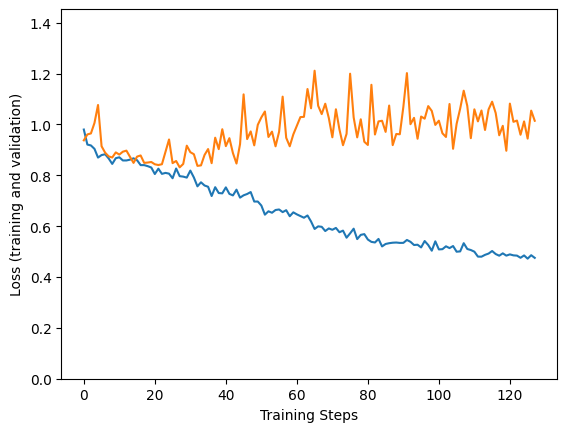

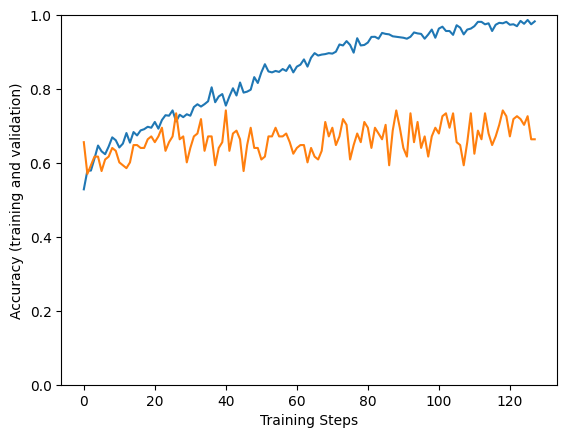

In [12]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,max(max(hist['loss']), max(hist['val_loss']))*1.2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

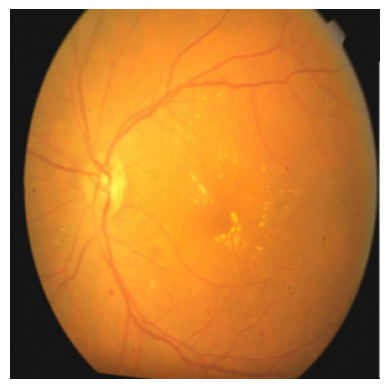

True label: female
Predicted label: female


In [13]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [14]:
num_cor = 0
# num_TP = 0
num_imgs = 0
# num_pos = 0
for x, y in test_ds:
    image = x[0, :, :, :]
    true_index = np.argmax(y[0])

    prediction_scores = model.predict(np.expand_dims(image, axis=0))
    predicted_index = np.argmax(prediction_scores)

    label_true = class_names[true_index]
    label_pred = class_names[predicted_index]

    if label_true == label_pred:
        num_cor += 1
    
    # if label_true == "male":
    #     num_GT = num_GT + 1

    # if label_pred:
    #     num_pos = num_pos + 1

    num_imgs = num_imgs + 1


# print(f"Precision: {num_TP/num_pos}")
# print(f"Recall: {num_TP/num_GT}")
print(f"Accuracy: {num_cor/num_imgs}")

Accuracy: 0.7450980392156863


In [15]:
label_true

'female'

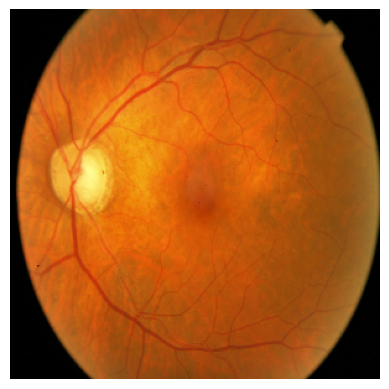

True label: female
Predicted label: female


In [16]:
# this is the test dataset
#
x, y = next(iter(test_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the test image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])